<a href="https://colab.research.google.com/github/flohmannjr/TCC530/blob/main/TCC530_Reprodu%C3%A7%C3%A3o_CFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TCC530 - Reprodução CFN

##Importações de bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

##Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

<ipython-input-2-be1f3b8ab2df>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


### Constantes

In [3]:
SEMENTE = 2008193

LIMITE_DICIONARIO = 60000

##Funções

In [4]:
class DCNN(tf.keras.Model):

  # Construtor da classe com passagem de parâmetros
  def __init__(self,
               vocab_size,    # Tamanho do vocabulário
               emb_dim,       # Tamanho da matriz de embbedings
               nb_filters,    # Número de filtros por região
               ffn_units,     # Feedforward - Número de neuronios da Rede neural densa
               dropout_rate,  # Zera percentual de neurônios para evitar overfetting
               training=True,
               name="dcnn"):

    super(DCNN, self).__init__(name=name)

    self.embedding = layers.Embedding(vocab_size, emb_dim)  # Gera matriz de palavras

    self.bigram   = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')  # Gera os filtros de tamanho 2
    self.trigram  = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')  # Gera os filtros de tamanho 3
    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')  # Gera os filtros de tamanho 4

    self.pool = layers.GlobalMaxPool1D()  # Etapa de maxpooling

    self.dense_1 = layers.Dense(units=ffn_units, activation='relu')  # Rede neural densa com ffn_unit definindo o numero de neuronios e função de ativação relu

    self.dropout = layers.Dropout(rate=dropout_rate)  # Passagem do parametro de dropout para evitar overfetting

    self.last_dense = layers.Dense(units=1, activation='sigmoid')  # Define a camada de saída com 1 bit e função de ativação sigmoid

  # Função que faz a "conexão" dos objetos da rede
  def call(self, inputs, training):

    x = self.embedding(inputs)  # Matriz de palavras recebe o texto

    x_1 = self.bigram(x)  # Filtros da região 3 recebem a matriz de palavras (região 3?)
    x_1 = self.pool(x_1)  # Executa o maxpooling no bigram

    x_2 = self.trigram(x)  # Filtros da região 2 recebem a matriz de palavras
    x_2 = self.pool(x_2)   # Executa o maxpooling no trigram

    x_3 = self.fourgram(x)  # Filtros da região 2 recebem a matriz de palavras (região 2?)
    x_3 = self.pool(x_3)    # Executa o maxpooling no fourgram

    merged = tf.concat([x_1, x_2, x_3], axis = -1)  # Faz a concatenação após o max pooling
    merged = self.dense_1(merged)                   # A camada primeira camada densa recebe o vetor concatenado
    merged = self.dropout(merged, training)         # Zera uma porção dos neurônios

    output = self.last_dense(merged)  # Liga a camada de dropout a camada de saída

    return output

def grafico_historico_por_iteracao(historico):

    for chave in historico.history.keys():
        sns.lineplot(data=historico.history[chave], label=chave)

    plt.title('Histórico por iteração')
    plt.xlabel('Iteração')
    plt.ylabel('')

    plt.legend(frameon=True, facecolor='white')
    plt.show()

def avaliar_modelo(validacao, previsao, rotulos=None, cmap='summer_r'):
    print(classification_report(validacao, previsao, target_names=rotulos))

    ConfusionMatrixDisplay.from_predictions(validacao, previsao, display_labels=rotulos, xticks_rotation='vertical', cmap=cmap)
    plt.grid(False)

    relatorio = classification_report(validacao, previsao, target_names=rotulos, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

##Dados

Fake.Br Corpus https://github.com/roneysco/Fake.br-Corpus

In [29]:
dados = pd.read_csv('https://raw.githubusercontent.com/roneysco/Fake.br-Corpus/master/preprocessed/pre-processed.csv',
                    index_col=['index'])

In [30]:
dados['label'].replace({'fake': 0, 'true': 1}, inplace=True)
dados['label'] = dados['label'].astype('Int32')

In [31]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 0 to 7199
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              7200 non-null   Int32 
 1   preprocessed_news  7200 non-null   object
dtypes: Int32(1), object(1)
memory usage: 147.7+ KB


In [32]:
dados

,label,preprocessed_news
index,,
0,0,katia abreu diz vai colocar expulsao moldura n...
1,0,ray peita bolsonaro conservador fake entrevist...
2,0,reinaldo azevedo desmascarado policia federal ...
3,0,relatorio assustador bndes mostra dinheiro pub...
4,0,radialista americano fala sobre pt vendem ilus...
...,...,...
7195,1,jornal britanico acao contra lula lava jato se...
7196,1,temer diz acionou pf cade investigar aumentos ...
7197,1,obstaculos politicos temer especialistas ouvid...


In [33]:
dados['label'].value_counts()

0    3600
1    3600
Name: label, dtype: Int64

In [34]:
X = dados['preprocessed_news']
y = dados['label']

### Tokenização

In [35]:
%%time

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(X, target_vocab_size=LIMITE_DICIONARIO)

CPU times: user 2min 9s, sys: 800 ms, total: 2min 9s
Wall time: 2min 10s


In [36]:
tokenizer.vocab_size

57046

In [37]:
print(tokenizer.subwords)

['nao_', 'lula_', 'ser_', 'sao_', 'tambem_', 'presidente_', 'disse_', 'sobre_', 'anos_', 'ja_', 'federal_', 'r_', 'governo_', 'ainda_', 'segundo_', 'brasil_', 'temer_', 'ate_', 'ha_', 'pais_', 'ter_', 'diz_', 'contra_', 'pessoas_', 'dia_', 'pode_', 'vai_', 'ano_', 'apos_', 'caso_', 'afirmou_', 'ministro_', 'justica_', 'estado_', 'porque_', 'milhoes_', 'acordo_', 'publico_', 'lava_', 'dilma_', 'policia_', 'jato_', 'paulo_', 'dois_', 'so_', 'defesa_', 'estao_', 'dinheiro_', 'fazer_', 'ministerio_', 'processo_', 'durante_', 'voce_', 'todos_', 'mil_', 'hoje_', 'rio_', 'casa_', 'outros_', 'operacao_', 'parte_', 'odebrecht_', 'nesta_', 'decisao_', 'alem_', 'tribunal_', 'sera_', 'republica_', 'pt_', 'onde_', 'juiz_', 'prisao_', 'empresa_', 'camara_', 'desde_', 'politica_', 'stf_', 'qualquer_', 'entao_', 'corrupcao_', 'moro_', 'agora_', 'grande_', 'seguranca_', 'grupo_', 'vez_', 'antes_', 'norte_', 'apenas_', 'dias_', 'mundo_', 'coreia_', 'tres_', 'nacional_', 'maior_', 'tudo_', 's_', 'conta_'

In [38]:
data_inputs = [tokenizer.encode(sentence) for sentence in X]

In [39]:
for _ in range(10):
    print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[4859, 161, 3742, 4, 1914, 760, 69, 4, 20850, 48, 38, 458, 1233, 19, 9686, 150, 2428, 38417, 16, 3742, 6216, 13987, 2657, 975, 821, 46, 13, 5, 2015, 168, 2894, 393, 2589, 1684, 419, 9, 6216, 4294, 1822, 890, 6251, 14130, 28361, 1640, 168, 2589, 819, 929, 314, 792, 9819, 869, 3794, 1252, 52676, 56822, 12, 36, 10, 792, 7532, 570, 5245, 3598, 754, 249, 12, 36, 602, 3742, 166, 1222, 29989, 240, 247, 13, 2718, 3827, 69, 245, 5, 12158, 48, 2894, 812, 1974, 9, 840, 22941, 12, 36, 43, 613, 5703, 12, 36, 393, 3000, 13, 602, 721, 16, 249, 12, 730, 75, 34451, 724, 2428, 754, 929, 95, 249, 12, 36, 4163, 31841, 792, 1449, 5, 2408, 600, 754, 2015, 12, 36, 12, 730, 4218, 27667]
[65, 14103, 13, 26, 732, 48, 59, 2535, 1179, 5266, 633, 57, 22, 1159, 32, 704, 7, 64, 8, 1337, 168, 50, 84, 142, 633, 1493, 146, 3, 1628, 1011, 90, 32, 704, 613, 1159, 7, 63, 950, 65, 732, 168, 580, 3, 4420, 14103, 964, 304, 13, 26, 7161, 633, 11, 57, 159, 48, 45790, 59, 2535, 4753, 1179, 497, 1222, 29, 1033, 661, 405, 16, 4, 

### Padding

In [40]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

4404

In [41]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding='post',
                                                            maxlen=max_len)

In [42]:
for _ in range(10):
    print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[353 348   7 ...   0   0   0]
[ 959  556 2937 ...    0    0    0]
[ 1588   546 15001 ...     0     0     0]
[ 493  503 8196 ...    0    0    0]
[ 505 5301 3017 ...    0    0    0]
[ 207 4790  507 ...    0    0    0]
[149 439  13 ...   0   0   0]
[1607  850 2833 ...    0    0    0]
[417 401 282 ...   0   0   0]
[26105  1784   920 ...     0     0     0]


### Separação

In [43]:
X_train, X_test, y_train, y_test = train_test_split(data_inputs,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEMENTE)

In [44]:
X_train = X_train.astype(np.int64)
X_test  = X_test.astype(np.int64)
y_train = y_train.astype(np.int64)
y_test  = y_test.astype(np.int64)

In [45]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5760, 4404), (1440, 4404), (5760,), (1440,))

In [46]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype

(dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'))

##Modelo

In [53]:
dcnn = DCNN(vocab_size=tokenizer.vocab_size,
            emb_dim=128,
            nb_filters=50,
            ffn_units=512,
            dropout_rate=0.1)

In [54]:
dcnn.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [55]:
%%time

historico = dcnn.fit(x=X_train,
                     y=y_train,
                     batch_size=64,
                     epochs=5,
                     validation_data=(X_test, y_test),
                     verbose=1)

Epoch 1/5
90/90 [==============================] - 23s 234ms/step - loss: 0.3203 - accuracy: 0.8562 - val_loss: 0.1067 - val_accuracy: 0.9569
Epoch 2/5
90/90 [==============================] - 20s 220ms/step - loss: 0.0520 - accuracy: 0.9837 - val_loss: 0.0806 - val_accuracy: 0.9688
Epoch 3/5
90/90 [==============================] - 18s 197ms/step - loss: 0.0066 - accuracy: 0.9990 - val_loss: 0.0742 - val_accuracy: 0.9708
Epoch 4/5
90/90 [==============================] - 20s 222ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0795 - val_accuracy: 0.9688
Epoch 5/5
90/90 [==============================] - 18s 196ms/step - loss: 4.8687e-04 - accuracy: 1.0000 - val_loss: 0.0804 - val_accuracy: 0.9688
CPU times: user 1min 16s, sys: 1.69 s, total: 1min 18s
Wall time: 2min 23s


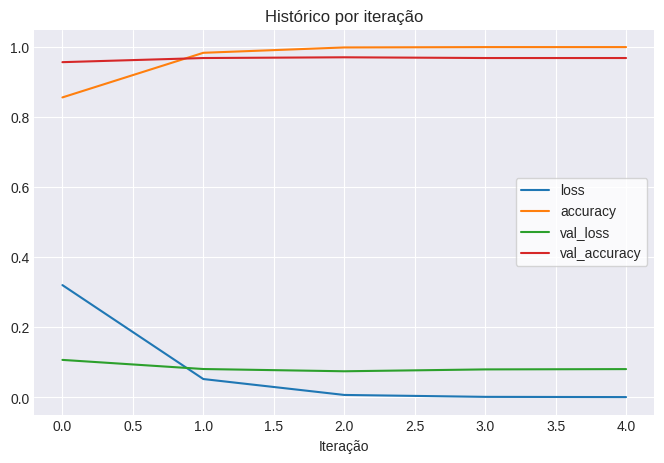

In [56]:
grafico_historico_por_iteracao(historico)

45/45 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       720
           1       0.98      0.96      0.97       720

    accuracy                           0.97      1440
   macro avg       0.97      0.97      0.97      1440
weighted avg       0.97      0.97      0.97      1440



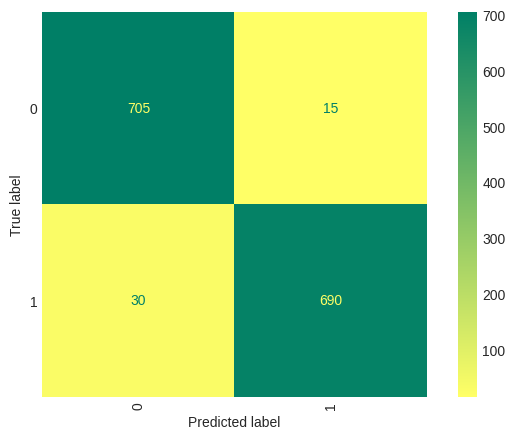

In [57]:
avaliacao      = dcnn.evaluate(X_test, y_test)
probabilidades = dcnn.predict(X_test)
previsoes      = tf.squeeze(tf.round(probabilidades))
relatorios     = avaliar_modelo(y_test, previsoes)

In [58]:
relatorios

{'acuracia': 0.96875,
 'precisao': 0.9689535388623534,
 'revocacao': 0.96875,
 'pontuacao-f1': 0.9687466087900163}